In [1]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
import h5py
import torch
import pickle
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
model_checkpoint_save_path = './models/checkpoints/'
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dtype)
print(device)

torch.float32
cuda:0


# Connect Colab and Google Drive

In [3]:
# Path to where deeplearningproject is stored on drive that contains the data and the git repo (may have to be changed depending on user)
# Note can just use Colab terminal with git commands to commit, pull, push, etc. (Note have to follow this to push: https://stackoverflow.com/a/65951928/14018615)
deep_learn_drive_path = '/content/drive/MyDrive/CS 6955/deeplearningproject/'
# To use with colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# cd into git repo
os.chdir(deep_learn_drive_path + 'cs-6955-deep-learning-final-project')
print('Git directory content: {0}'.format(os.listdir()))

Git directory content: ['porositydata_howto.py', '.git', 'README.md', 'models', 'porositydataset.hdf5', '.gitignore', 'porositydataset_2000runs.hdf5', 'PorousMaterialImageToYoungsModulusNet.ipynb']


# Visualize Data

In [5]:
##load the dataset
porosity_dataset_filename = 'porositydataset_2000runs.hdf5'
# porosity_dataset_filename = 'porositydataset.hdf5'
d = h5py.File(porosity_dataset_filename,'a')
print(d.keys())
#load original images
og_images = np.zeros(d['Original Images'].shape)
og_images[:,:,:] = d['Original Images']
#load deformed images
deformed_images = np.zeros(d['Deformed Images'].shape)
deformed_images[:,:,:] = d['Deformed Images']
#load stress-strain data
data = np.zeros(d['Data'].shape)
data[:,:,:] = d['Data']
#separate stresses/strains, stresses in MPa, strain is unitless
SMises = data[:,0,:] #von Mises stress
S11 = data[:,1,:] #stress in 11 direction
S22 = data[:,2,:] #stress in 22 direction
SP = data[:,3,:] #pressure stress
strain = data[:,4,:]*0.006 #strain (have to multiply by 0.006 to get value)
#load youngs moduli, units are GPa
E = np.zeros(d['Youngs Modulus'].shape)
E[:] = d['Youngs Modulus']


<KeysViewHDF5 ['Data', 'Deformed Images', 'Original Images', 'Youngs Modulus']>


Youngs Modulus: 169.34269981089005 GPa
(2000, 256, 256, 3)


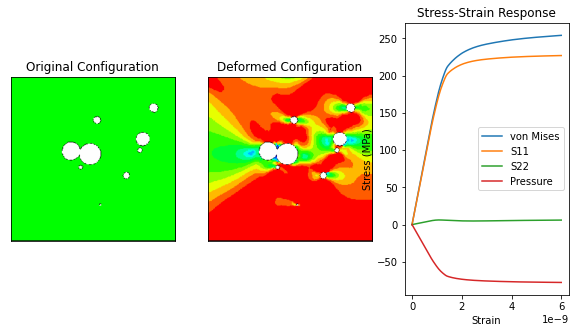



Youngs Modulus: 135.9029917741759 GPa
(2000, 256, 256, 3)


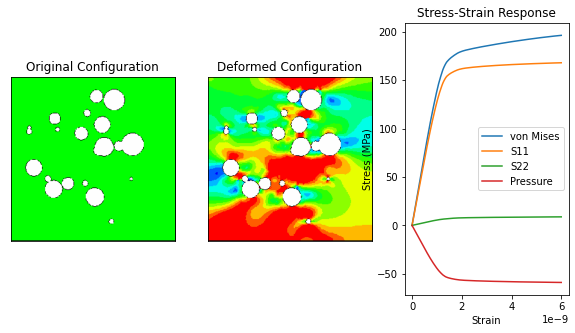



Youngs Modulus: 183.23642303249696 GPa
(2000, 256, 256, 3)


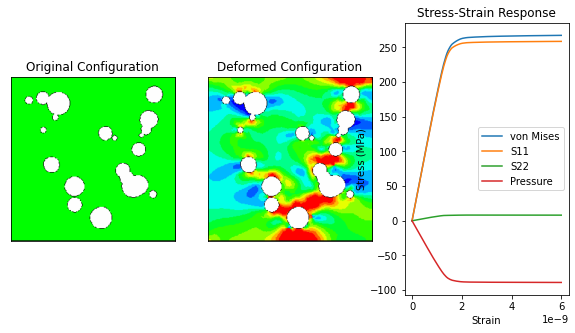



Youngs Modulus: 152.62857899875183 GPa
(2000, 256, 256, 3)


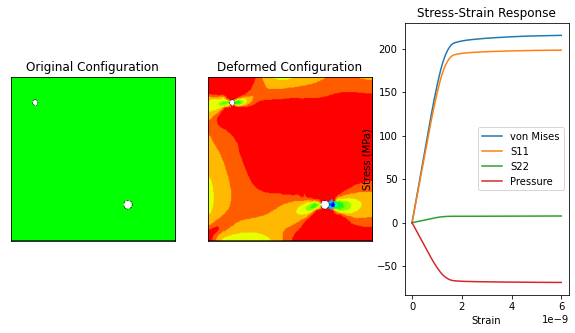



Youngs Modulus: 198.73067345644105 GPa
(2000, 256, 256, 3)


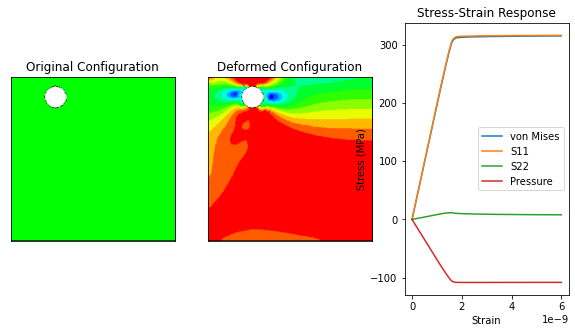

In [6]:
for _ in range(5):
    #choose which run you want to look at
    run = random.randint(0, E.size-1)
    #print youngs modulus
    print('Youngs Modulus:',E[run],'GPa')
    #plot images and stress response
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.imshow(og_images[run,:,:,:].astype('uint8'))
    print(og_images.shape)
    ax1.title.set_text('Original Configuration')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(deformed_images[run,:,:,:].astype('uint8'))
    ax2.title.set_text('Deformed Configuration')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.plot(strain[run,:],SMises[run,:],label='von Mises')
    ax3.plot(strain[run,:],S11[run,:],label='S11')
    ax3.plot(strain[run,:],S22[run,:],label='S22')
    ax3.plot(strain[run,:],SP[run,:],label='Pressure')
    ax3.title.set_text('Stress-Strain Response')
    ax3.set_xlabel('Strain')
    ax3.set_ylabel('Stress (MPa)')
    ax3.legend()
    plt.show()
    print()
    print()
del d, og_images, deformed_images, data, SMises, S11, S22, SP, strain, E

# Create PyTorch Dataset 

In [7]:
class PorousMaterialImageToYoungsModulusDataset(Dataset):
    def __init__(self, hdf5_porosity_path, img_transform=None):
        self.img_transform = img_transform
        ##load the dataset
        self.d = h5py.File(hdf5_porosity_path,'a')
        #load original images
        self.og_images = np.zeros(self.d['Original Images'].shape)
        self.og_images[:,:,:] = self.d['Original Images']
        #load deformed images
        self.deformed_images = np.zeros(self.d['Deformed Images'].shape)
        self.deformed_images[:,:,:] = self.d['Deformed Images']
        #load stress-strain data
        self.ss_data = np.zeros(self.d['Data'].shape)
        self.ss_data[:,:,:] = self.d['Data']
        #separate stresses/strains, stresses in MPa, strain is unitless
        self.SMises = self.ss_data[:,0,:] #von Mises stress
        self.S11 = self.ss_data[:,1,:] #stress in 11 direction
        self.S22 = self.ss_data[:,2,:] #stress in 22 direction
        self.SP = self.ss_data[:,3,:] #pressure stress
        self.strain = self.ss_data[:,4,:]*0.006 #strain (have to multiply by 0.006 to get value)
        #load youngs moduli, units are GPa
        self.E = np.zeros(self.d['Youngs Modulus'].shape)
        self.E[:] = self.d['Youngs Modulus']
        
    def __len__(self):
        return self.E.size

    def __getitem__(self, idx):
        og_image_idx = self.og_images[idx,:,:,:].astype('uint8')
        deformed_image_idx = self.deformed_images[idx,:,:,:].astype('uint8')
        if (self.img_transform is not None):
            og_image_idx = self.img_transform(og_image_idx)
            deformed_image_idx = self.img_transform(deformed_image_idx)
        SMises_idx = self.SMises[idx,:]
        S11_idx = self.S11[idx,:]
        S22_idx = self.S22[idx,:]
        SP_idx = self.SP[idx,:]
        strain_idx = self.strain[idx,:]
        E_idx = self.E[idx]
        # return og_image_idx, SMises_idx, S11_idx, S22_idx, SP_idx, SP_idx, strain_idx, E_idx
        # Have to decide what exactly to return here, depends on training task
        # For now will have og_image_idx be the feature and E_idx be the label
        image = og_image_idx
        label = E_idx
        return image, label

In [8]:
# Load porous dataset into memory
porous_dataset = PorousMaterialImageToYoungsModulusDataset(porosity_dataset_filename, img_transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize(224), transforms.ToTensor()]))

In [9]:
# Split into train and test
test_prop = 0.2
test_size = int(test_prop*len(porous_dataset))
train_size = len(porous_dataset) - test_size
porous_train_dataset, porous_test_dataset = random_split(porous_dataset, (train_size, test_size)) 

# Split train into train and val
val_prop = 0.2
val_size = int(val_prop*len(porous_train_dataset))
train_size = len(porous_train_dataset) - val_size
porous_train_dataset, porous_val_dataset = random_split(porous_train_dataset, (train_size, val_size)) 

In [10]:
batch_size = 32
train_loader = DataLoader(porous_train_dataset, batch_size=batch_size, shuffle=True)

# Batch size doesn't really matter for testing
test_loader = DataLoader(porous_test_dataset)
val_loader = DataLoader(porous_val_dataset)

Label: 168.6852147378788 GPa
torch.Size([3, 224, 224])


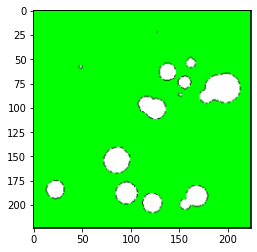



Label: 185.4336684879721 GPa
torch.Size([3, 224, 224])


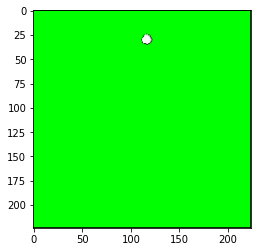



Label: 179.68583672569707 GPa
torch.Size([3, 224, 224])


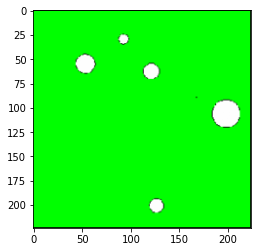



Label: 160.79001929758545 GPa
torch.Size([3, 224, 224])


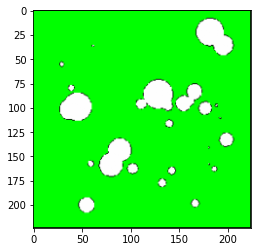



Label: 192.11587107760204 GPa
torch.Size([3, 224, 224])


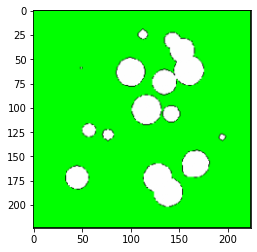



Label: 198.05252314333146 GPa
torch.Size([3, 224, 224])


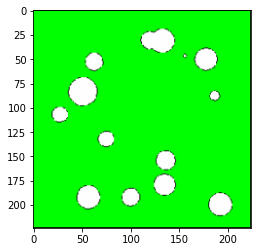



Label: 183.04777621842868 GPa
torch.Size([3, 224, 224])


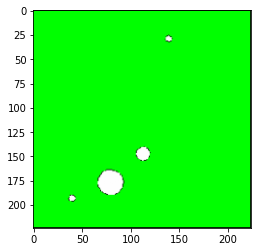



Label: 185.4927534381153 GPa
torch.Size([3, 224, 224])


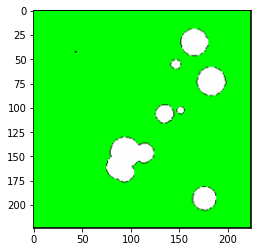



Label: 123.34356304689786 GPa
torch.Size([3, 224, 224])


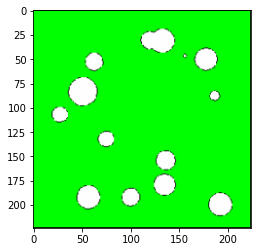



Label: 184.90402276208326 GPa
torch.Size([3, 224, 224])


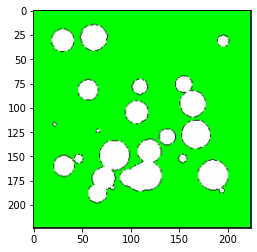



Label: 173.77057020933793 GPa
torch.Size([3, 224, 224])


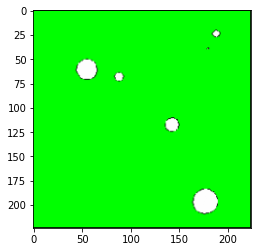



Label: 191.70920195091838 GPa
torch.Size([3, 224, 224])


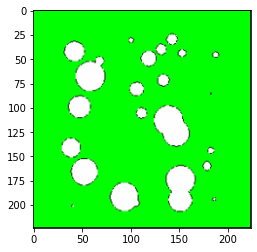



Label: 171.95600615565914 GPa
torch.Size([3, 224, 224])


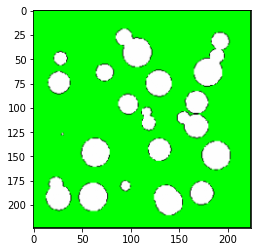



Label: 174.01776144623219 GPa
torch.Size([3, 224, 224])


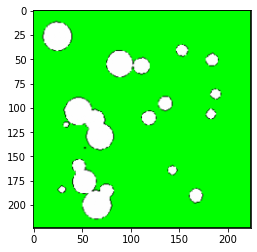



Label: 194.58667857710464 GPa
torch.Size([3, 224, 224])


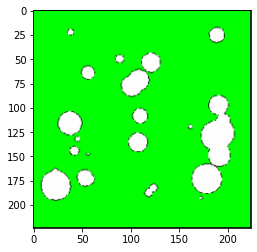



Label: 202.37811210030716 GPa
torch.Size([3, 224, 224])


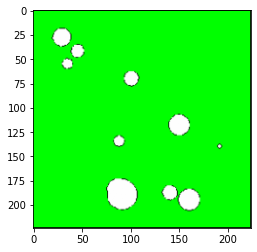



Label: 194.136047918706 GPa
torch.Size([3, 224, 224])


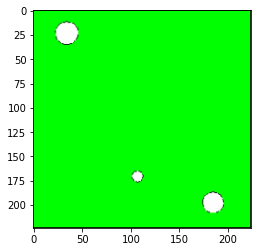



Label: 164.6277090162811 GPa
torch.Size([3, 224, 224])


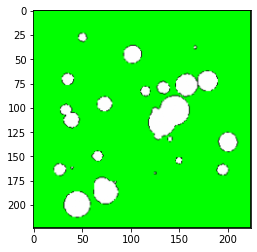



Label: 148.24828119097293 GPa
torch.Size([3, 224, 224])


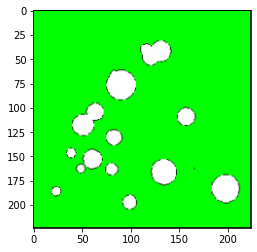



Label: 179.2184944219335 GPa
torch.Size([3, 224, 224])


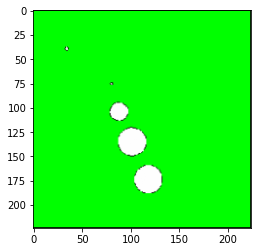



Label: 172.6917275091754 GPa
torch.Size([3, 224, 224])


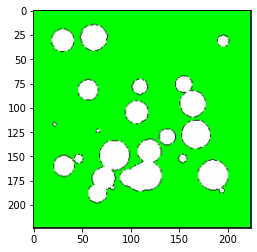



Label: 146.3524013868143 GPa
torch.Size([3, 224, 224])


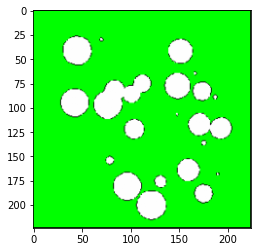



Label: 147.8920483796167 GPa
torch.Size([3, 224, 224])


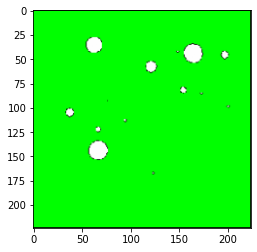



Label: 158.47167629578666 GPa
torch.Size([3, 224, 224])


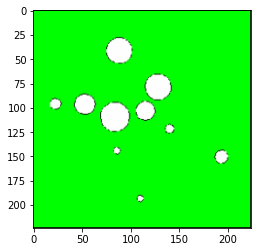



Label: 200.22869720230918 GPa
torch.Size([3, 224, 224])


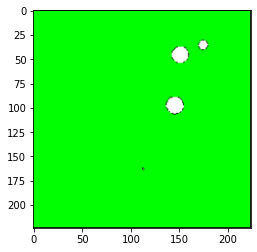



Label: 181.6659965315665 GPa
torch.Size([3, 224, 224])


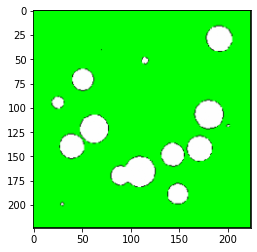



Label: 176.8088391561051 GPa
torch.Size([3, 224, 224])


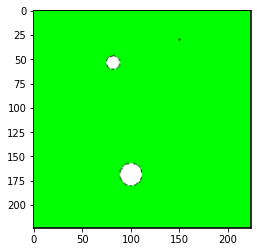



Label: 189.4782432227956 GPa
torch.Size([3, 224, 224])


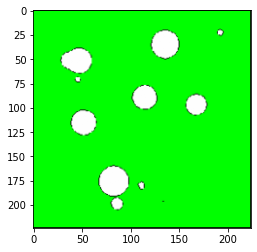



Label: 196.0573233764431 GPa
torch.Size([3, 224, 224])


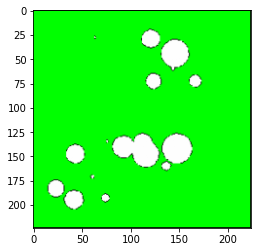



Label: 191.70920195091838 GPa
torch.Size([3, 224, 224])


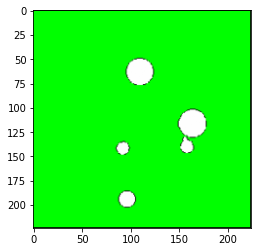



Label: 151.14099376851541 GPa
torch.Size([3, 224, 224])


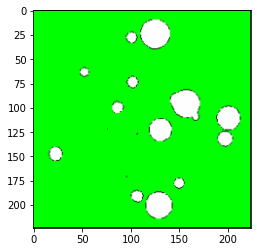



Label: 141.38361151848258 GPa
torch.Size([3, 224, 224])


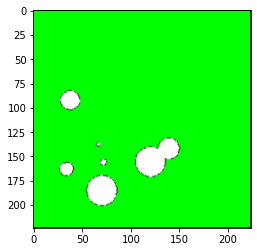

In [11]:
# Visualize train data of a random batch 
viz_batch_idx = random.randint(0, len(train_loader)-1)
for i, batch in enumerate(train_loader):
    if i != viz_batch_idx:
        continue
    train_features, train_labels = batch
    for idx in range(len(train_features)):
        print("Label: {0} GPa".format(train_labels[idx].item()))
        plt.figure()
        print(train_features[idx].shape)
        plt.imshow(torch.movedim(train_features[idx], 0, 2))
        plt.show()
        print()
        print()


# Training

In [12]:
class PorousMaterialImageToYoungsModulusNet(nn.Module):
    def __init__(self):
        super().__init__()
        squeeze_net_model = nn.Sequential(*list(models.squeezenet1_1(pretrained=False).children()))
        self.model = torch.nn.Sequential(
            squeeze_net_model,
            nn.Flatten(),
            nn.Linear(1000, 1)
            )

    def forward(self, porous_material_image):
        scores = self.model(porous_material_image)
        return torch.flatten(scores, start_dim=1, end_dim=1)



In [19]:
def get_PorousMaterialImageToYoungsModulusNet_accuracy(model, evaluation_dataloader, criterion):
    model.eval()
    model = model.to(device=device)
    total_MSE = 0
    num_vals = 0
    with torch.no_grad():
        for eval_val in evaluation_dataloader:
            feat, label, = eval_val
            feat = feat.to(dtype=dtype, device=device)
            label = label.to(dtype=dtype, device=device)

            pred_label = torch.flatten(model(feat))
            total_MSE += criterion(pred_label, label).cpu().item()
            num_vals += 1
    avg_MSE = total_MSE / num_vals
    return total_MSE, avg_MSE 

In [20]:
model = PorousMaterialImageToYoungsModulusNet()

learning_rate = 1e-3
nepochs = 100 
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
train_avg_MSE_vals = []
val_avg_MSE_vals = []
date_str = datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
model_save_name = 'model_{0}.pt'.format(date_str)
model_save_path = '{0}{1}'.format(model_checkpoint_save_path, model_save_name)
model_training_info_name = 'model_{0}_training_info.pkl'.format(date_str)
model_training_info_name_path = '{0}{1}'.format(model_checkpoint_save_path, model_training_info_name)
best_val_avg_MSE = 1000  
model = model.to(device=device)
for e in range(nepochs):
    model.train() # Will put model in training mode
    print("Begin epoch {0}".format(e))
    for batch in train_loader:
        train_features, train_labels = batch
        train_features = train_features.to(dtype=dtype, device=device)
        train_labels = train_labels.to(dtype=dtype, device=device)

        pred_labels = torch.flatten(model(train_features))
        loss = criterion(pred_labels, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    _, current_train_avg_MSE = get_PorousMaterialImageToYoungsModulusNet_accuracy(model, train_loader, criterion) # Will put model in eval mode
    _, current_val_avg_MSE = get_PorousMaterialImageToYoungsModulusNet_accuracy(model, val_loader, criterion) # Will put model in eval mode
    train_avg_MSE_vals.append(current_train_avg_MSE)
    val_avg_MSE_vals.append(current_val_avg_MSE)
    if current_val_avg_MSE < best_val_avg_MSE:
        torch.save({
            'epoch':e,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'avg_train_loss':current_train_avg_MSE,
            'avg_val_loss':current_val_avg_MSE
        }, model_save_path)
        best_val_avg_MSE = current_val_avg_MSE
    print("Epoch {0}: train avg MSE={1}, val avg MSE={2}\n\n".format(e, current_train_avg_MSE, current_val_avg_MSE))
with open(model_training_info_name_path, 'wb') as f:
    pickle.dump((train_avg_MSE_vals, val_avg_MSE_vals),f)


Begin epoch 0
Epoch 0: train avg MSE=351.6411563873291, val avg MSE=386.8445229082645


Begin epoch 1
Epoch 1: train avg MSE=357.37819519042966, val avg MSE=399.7960551513417


Begin epoch 2
Epoch 2: train avg MSE=327.834033203125, val avg MSE=364.6198780384264


Begin epoch 3
Epoch 3: train avg MSE=329.6946662902832, val avg MSE=368.92298321698615


Begin epoch 4
Epoch 4: train avg MSE=471.83692626953126, val avg MSE=494.6355411357043


Begin epoch 5
Epoch 5: train avg MSE=332.63392181396483, val avg MSE=365.94623593713914


Begin epoch 6
Epoch 6: train avg MSE=324.5572063446045, val avg MSE=361.1007806841641


Begin epoch 7
Epoch 7: train avg MSE=337.9477306365967, val avg MSE=378.6064171788195


Begin epoch 8
Epoch 8: train avg MSE=395.6952033996582, val avg MSE=423.85631201400537


Begin epoch 9
Epoch 9: train avg MSE=756.8063385009766, val avg MSE=770.9567830924876


Begin epoch 10
Epoch 10: train avg MSE=370.74269943237306, val avg MSE=401.47512476565316


Begin epoch 11
Epoch 11

## Display Training Results

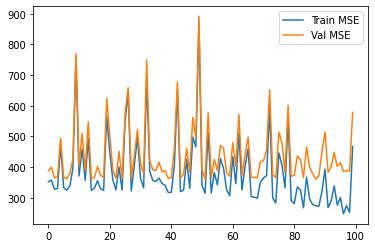

In [24]:
with open(model_training_info_name_path, 'rb') as f:
    train_avg_MSE_vals, val_avg_MSE_vals = pickle.load(f)
plt.figure()
plt.plot(train_avg_MSE_vals, label='Train MSE')
plt.plot(val_avg_MSE_vals, label='Val MSE')
plt.legend()
plt.show()

In [27]:
best_model = PorousMaterialImageToYoungsModulusNet()
best_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_checkpoint = torch.load(model_save_path)
best_epoch = best_checkpoint['epoch']
best_model.load_state_dict(best_checkpoint['model_state_dict'])
best_optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])
best_train_loss = best_checkpoint['avg_train_loss']
best_val_loss = best_checkpoint['avg_val_loss']

print('Best epoch = {0}, best train avg MSE loss = {1}, best val avg MSE loss = {2}'.format(best_epoch, best_train_loss, best_val_loss))

Best epoch = 87, best train avg MSE loss = 274.0203353881836, best val avg MSE loss = 360.6669094455734


## Test Results

In [29]:
test_total_MSE, test_avg_MSE = get_PorousMaterialImageToYoungsModulusNet_accuracy(best_model, test_loader, criterion)
print('Best val set model: test total MSE = {0}GPa**2, test avg MSE = {1}GPa**2'.format(test_total_MSE, test_avg_MSE))
print('Best val set model: test total sqrt(MSE) = {0}GPa, test avg sqrt(MSE) = {1}GPa'.format(np.sqrt(test_total_MSE), np.sqrt(test_avg_MSE)))

Best val set model: test total MSE = 129531.36369784852GPa**2, test avg MSE = 323.8284092446213GPa**2
Best val set model: test total sqrt(MSE) = 359.90465917774463GPa, test avg sqrt(MSE) = 17.995232958887232GPa
